In [1]:
# For Data Processing
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image, ImageEnhance

# For ML Models
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.models import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing.image import load_img

# For Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Miscellaneous
from tqdm import tqdm
import os
import random

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
train_dir = '/content/drive/MyDrive/skin_cancer_dataset/ISBI2017_dataset/train/'
test_dir = '/content/drive/MyDrive/skin_cancer_dataset/ISBI2017_dataset/test/'

train_paths = []
train_labels = []

for label in os.listdir(train_dir):
    for image in os.listdir(train_dir+label):
        train_paths.append(train_dir+label+'/'+image)
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

In [5]:
test_paths = []
test_labels = []

for label in os.listdir(test_dir):
    for image in os.listdir(test_dir+label):
        test_paths.append(test_dir+label+'/'+image)
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

In [6]:
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8,1.2))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8,1.2))
    image = np.array(image)/255.0
    return image

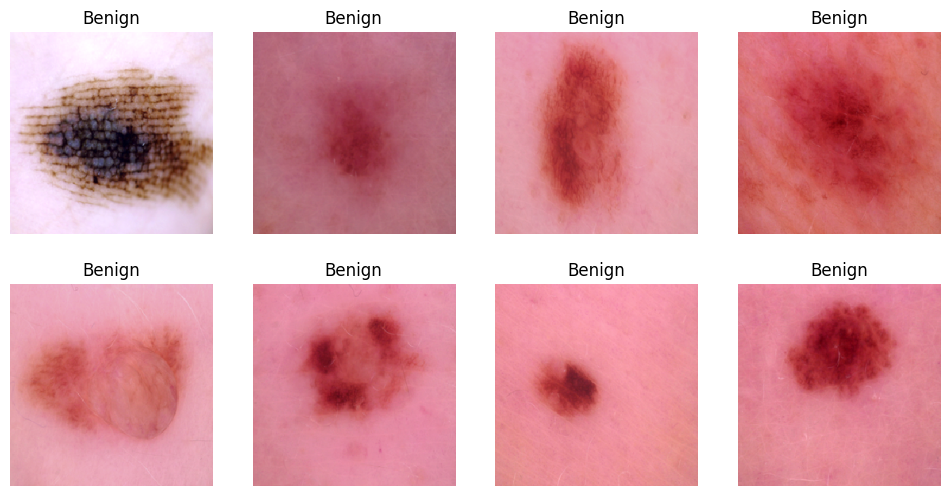

In [7]:
IMAGE_SIZE = 256

def open_images(paths):
    '''
    Given a list of paths to images, this function returns the images as arrays (after augmenting them)
    '''
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE,IMAGE_SIZE))
        image = augment_image(image)
        images.append(image)
    return np.array(images)

images = open_images(train_paths[50:59])
labels = train_labels[50:59]
fig = plt.figure(figsize=(12, 6))
for x in range(1, 9):
    fig.add_subplot(2, 4, x)
    plt.axis('off')
    plt.title(labels[x])
    plt.imshow(images[x])
plt.rcParams.update({'font.size': 20})
plt.show()

In [8]:
unique_labels = os.listdir(train_dir)

def encode_label(labels):
    encoded = []
    for x in labels:
        encoded.append(unique_labels.index(x))
    return np.array(encoded)

def decode_label(labels):
    decoded = []
    for x in labels:
        decoded.append(unique_labels[x])
    return np.array(decoded)

def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for x in range(0, len(paths), batch_size):
            batch_paths = paths[x:x+batch_size]
            batch_images = open_images(batch_paths)
            batch_labels = labels[x:x+batch_size]
            batch_labels = encode_label(batch_labels)
            yield batch_images, batch_labels

In [9]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from keras.optimizers import Adam
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, Average, Input, Concatenate, GlobalMaxPooling2D,BatchNormalization

In [10]:
# Values are from table 4.
patch_size = 4  # 2x2, for the Transformer blocks.
image_size = 256
expansion_factor = 2  # expansion factor for the MobileNetV2 blocks.

In [11]:
def conv_block(x, filters=16, kernel_size=3, strides=2):
    conv_layer = layers.Conv2D(
        filters,
        kernel_size,
        strides=strides,
        activation=keras.activations.swish,
        padding="same",
    )
    return conv_layer(x)


# Reference: https://github.com/keras-team/keras/blob/e3858739d178fe16a0c77ce7fab88b0be6dbbdc7/keras/applications/imagenet_utils.py#L413C17-L435


def correct_pad(inputs, kernel_size):
    img_dim = 2 if backend.image_data_format() == "channels_first" else 1
    input_size = inputs.shape[img_dim : (img_dim + 2)]
    if isinstance(kernel_size, int):
        kernel_size = (kernel_size, kernel_size)
    if input_size[0] is None:
        adjust = (1, 1)
    else:
        adjust = (1 - input_size[0] % 2, 1 - input_size[1] % 2)
    correct = (kernel_size[0] // 2, kernel_size[1] // 2)
    return (
        (correct[0] - adjust[0], correct[0]),
        (correct[1] - adjust[1], correct[1]),
    )


# Reference: https://git.io/JKgtC


def inverted_residual_block(x, expanded_channels, output_channels, strides=1):
    m = layers.Conv2D(expanded_channels, 1, padding="same", use_bias=False)(x)
    m = layers.BatchNormalization()(m)
    m = keras.activations.swish(m)

    if strides == 2:
        m = layers.ZeroPadding2D(padding=correct_pad(m, 3))(m)
    m = layers.DepthwiseConv2D(
        3, strides=strides, padding="same" if strides == 1 else "valid", use_bias=False
    )(m)
    m = layers.BatchNormalization()(m)
    m = keras.activations.swish(m)

    m = layers.Conv2D(output_channels, 1, padding="same", use_bias=False)(m)
    m = layers.BatchNormalization()(m)

    if keras.ops.equal(x.shape[-1], output_channels) and strides == 1:
        return layers.Add()([m, x])
    return m


# Reference:
# https://keras.io/examples/vision/image_classification_with_vision_transformer/


def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=keras.activations.swish)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


def transformer_block(x, transformer_layers, projection_dim, num_heads=2):
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(x)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, x])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(
            x3,
            hidden_units=[x.shape[-1] * 2, x.shape[-1]],
            dropout_rate=0.1,
        )
        # Skip connection 2.
        x = layers.Add()([x3, x2])

    return x


def mobilevit_block(x, num_blocks, projection_dim, strides=1):
    # Local projection with convolutions.
    local_features = conv_block(x, filters=projection_dim, strides=strides)
    local_features = conv_block(
        local_features, filters=projection_dim, kernel_size=1, strides=strides
    )

    # Unfold into patches and then pass through Transformers.
    num_patches = int((local_features.shape[1] * local_features.shape[2]) / patch_size)
    non_overlapping_patches = layers.Reshape((patch_size, num_patches, projection_dim))(
        local_features
    )
    global_features = transformer_block(
        non_overlapping_patches, num_blocks, projection_dim
    )

    # Fold into conv-like feature-maps.
    folded_feature_map = layers.Reshape((*local_features.shape[1:-1], projection_dim))(
        global_features
    )

    # Apply point-wise conv -> concatenate with the input features.
    folded_feature_map = conv_block(
        folded_feature_map, filters=x.shape[-1], kernel_size=1, strides=strides
    )
    local_global_features = layers.Concatenate(axis=-1)([x, folded_feature_map])

    # Fuse the local and global features using a convoluion layer.
    local_global_features = conv_block(
        local_global_features, filters=projection_dim, strides=strides
    )

    return local_global_features

In [12]:
import keras
from keras import layers
from keras import backend
# Model
def create_mobilevit(num_classes=2):
    inputs = keras.Input((image_size, image_size, 3))
    x = layers.Rescaling(scale=1.0 / 255)(inputs)

    # Initial conv-stem -> MV2 block.
    x = conv_block(x, filters=16)
    x = inverted_residual_block(
        x, expanded_channels=16 * expansion_factor, output_channels=16
    )

    # Downsampling with MV2 block.
    x = inverted_residual_block(
        x, expanded_channels=16 * expansion_factor, output_channels=24, strides=2
    )
    x = inverted_residual_block(
        x, expanded_channels=24 * expansion_factor, output_channels=24
    )
    x = inverted_residual_block(
        x, expanded_channels=24 * expansion_factor, output_channels=24
    )

    # First MV2 -> MobileViT block.
    x = inverted_residual_block(
        x, expanded_channels=24 * expansion_factor, output_channels=48, strides=2
    )
    x = mobilevit_block(x, num_blocks=2, projection_dim=64)

    # Second MV2 -> MobileViT block.
    x = inverted_residual_block(
        x, expanded_channels=64 * expansion_factor, output_channels=64, strides=2
    )
    x = mobilevit_block(x, num_blocks=4, projection_dim=80)

    # Third MV2 -> MobileViT block.
    x = inverted_residual_block(
        x, expanded_channels=80 * expansion_factor, output_channels=80, strides=2
    )
    x = mobilevit_block(x, num_blocks=3, projection_dim=96)
    x = conv_block(x, filters=320, kernel_size=1, strides=1)

    # Classification head.
    x = layers.GlobalAvgPool2D()(x)
    x = layers.Dropout(0.4)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(256,activation='relu')(x)
    x = layers.Dense(128,activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    return keras.Model(inputs, outputs)

mobilevit_model = create_mobilevit()
mobilevit_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 256, 256, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 16)   │            448 │ rescaling[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 32)   │            512 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 128, 128, 32)   │            128 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ silu (Silu)               │ (None, 128, 128, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ depthwise_conv2d          │ (None, 128, 128, 32)   │            288 │ silu[0][0]             │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 128, 128, 32)   │            128 │ depthwise_conv2d[0][0] │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ silu_1 (Silu)             │ (None, 128, 128, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 16)   │            512 │ silu_1[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 128, 128, 16)   │             64 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 128, 128, 16)   │              0 │ batch_normalization_2… │
│                           │                        │                │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 32)   │            512 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 128, 128, 32)   │            128 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ silu_2 (Silu)             │ (None, 128, 128, 32)   │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 129, 129, 32)   │              0 │ silu_2[0][0]           │
│ (ZeroPadding2D)           │                        │                │                        │
├──────────────────────

 Total params: 1,422,626 (5.43 MB)

 Trainable params: 1,419,442 (5.41 MB)

 Non-trainable params: 3,184 (12.44 KB)

In [13]:
mobilevit_model.compile(optimizer=Adam(learning_rate=0.0001),
             loss='sparse_categorical_crossentropy',
             metrics=['sparse_categorical_accuracy'])

In [14]:
batch_size = 32
steps = int(len(train_paths)/batch_size)
epochs = 40
history = mobilevit_model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

Epoch 1/40
56/56 ━━━━━━━━━━━━━━━━━━━━ 941s 15s/step - loss: 0.5841 - sparse_categorical_accuracy: 0.6807
Epoch 2/40
56/56 ━━━━━━━━━━━━━━━━━━━━ 77s 337ms/step - loss: 0.3008 - sparse_categorical_accuracy: 0.8541
Epoch 3/40
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 348ms/step - loss: 0.2899 - sparse_categorical_accuracy: 0.8765
Epoch 4/40
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 335ms/step - loss: 0.2117 - sparse_categorical_accuracy: 0.9191
Epoch 5/40
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 342ms/step - loss: 0.1626 - sparse_categorical_accuracy: 0.9426
Epoch 6/40
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 340ms/step - loss: 0.1566 - sparse_categorical_accuracy: 0.9338
Epoch 7/40
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 336ms/step - loss: 0.1512 - sparse_categorical_accuracy: 0.9429
Epoch 8/40
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 346ms/step - loss: 0.1408 - sparse_categorical_accuracy: 0.9465
Epoch 9/40
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 335ms/step - loss: 0.1155 - sparse_categorical_accuracy: 0.9518
Epoch 10/40
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 349m

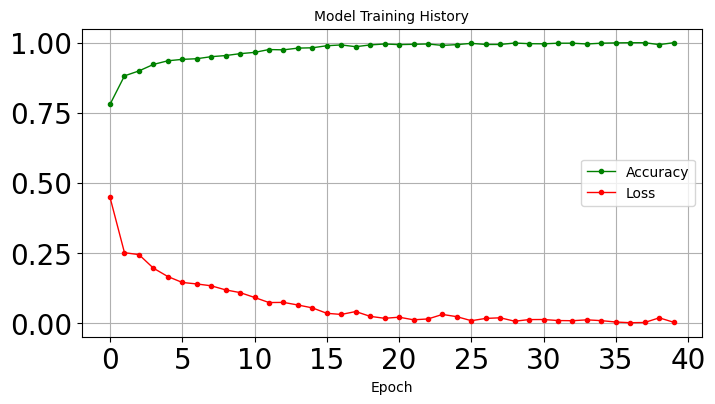

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=1)
plt.plot(history.history['loss'], '.r-', linewidth=1)
plt.title('Model Training History', fontsize=10)
plt.xlabel('Epoch', fontsize=10)

# Set xticks to increment by 4, starting from 1
plt.xticks(range(0, epochs+1, 5))

plt.legend(['Accuracy', 'Loss'], loc='center right', fontsize=10)
plt.show()

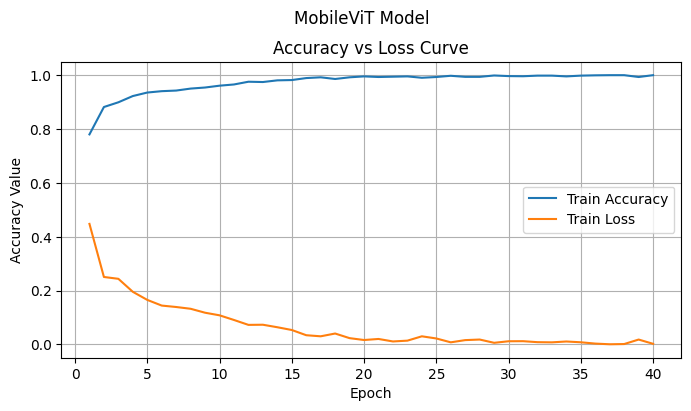

In [16]:
import matplotlib.pyplot as plt
plt.style.use('default')
f, ax1 = plt.subplots(figsize=(8, 4))
t = f.suptitle('MobileViT Model', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,41))
ax1.plot(epoch_list, history.history['sparse_categorical_accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['loss'], label='Train Loss')
ax1.grid()
ax1.set_xticks(np.arange(0, 41, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy vs Loss Curve')
l1 = ax1.legend(loc="best")

# Federated Learning Based transfer Learning enabled Xception Model

In [18]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the number of clients and the number of training rounds
NUM_CLIENTS = 4
NUM_ROUNDS = 3


# Define the clients and their data
clients = []
for i in range(NUM_CLIENTS):
    client_data = train_paths[i * (len(train_paths) // NUM_CLIENTS):(i + 1) * (len(train_paths) // NUM_CLIENTS)]
    client_labels = train_labels[i * (len(train_labels) // NUM_CLIENTS):(i + 1) * (len(train_labels) // NUM_CLIENTS)]
    clients.append((client_data, client_labels))

# Federated learning loop
for round_num in range(NUM_ROUNDS):

    # Select clients
    selected_client_indices = np.random.choice(len(clients), size=int(NUM_CLIENTS * 0.5), replace=False)
    selected_clients = [clients[i] for i in selected_client_indices]

    # Transmit the global model to the selected clients
    for client in selected_clients:
        client_model = tf.keras.models.clone_model(mobilevit_model)
        client_model.set_weights(mobilevit_model.get_weights())

        # Compile the client model
        client_model.compile(optimizer=Adam(learning_rate=0.0001),
        loss='sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy'])

        steps_per_epoch = int(len(client[0]) / 20)


        client_model.fit(datagen(client[0],client[1], batch_size=batch_size, epochs=epochs),
                         epochs=5, steps_per_epoch=steps_per_epoch)

        # Train locally
        steps_per_epoch = int(len(client[0]) / 20)

        # Aggregate the model
        new_weights = []
        for layer_index in range(len(mobilevit_model.get_weights())):
            new_layer_weights = np.mean([client_model.get_weights()[layer_index], mobilevit_model.get_weights()[layer_index]], axis=0)
            new_weights.append(new_layer_weights)
        mobilevit_model.set_weights(new_weights)


batch_size = 32
steps = int(len(test_paths)/batch_size)
y_pred = []
y_true = []
for x,y in tqdm(datagen(test_paths, test_labels, batch_size=batch_size, epochs=1), total=steps):
    pred = mobilevit_model.predict(x)
    pred = np.argmax(pred, axis=-1)
    for i in decode_label(pred):
        y_pred.append(i)
    for i in decode_label(y):
        y_true.append(i)

# Deploy the model
mobilevit_model.save('my_model.h5')

Epoch 1/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 148s 3s/step - loss: 0.0213 - sparse_categorical_accuracy: 0.9975
Epoch 2/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 335ms/step - loss: 0.0316 - sparse_categorical_accuracy: 0.9926
Epoch 3/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 302ms/step - loss: 0.3504 - sparse_categorical_accuracy: 0.9695
Epoch 4/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 339ms/step - loss: 0.0310 - sparse_categorical_accuracy: 0.9931
Epoch 5/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 298ms/step - loss: 0.0536 - sparse_categorical_accuracy: 0.9882
Epoch 1/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 149s 3s/step - loss: 0.0011 - sparse_categorical_accuracy: 1.0000
Epoch 2/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 351ms/step - loss: 0.0137 - sparse_categorical_accuracy: 0.9983
Epoch 3/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 328ms/step - loss: 0.0405 - sparse_categorical_accuracy: 0.9942
Epoch 4/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 344ms/step - loss: 8.9173e-04 - sparse_categorical_accuracy: 1.0000
Epoch 5/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 316ms/step - loss: 0.0

  0%|          | 0/18 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


  6%|▌         | 1/18 [00:24<07:03, 24.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 11%|█         | 2/18 [00:38<04:55, 18.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


 17%|█▋        | 3/18 [00:53<04:08, 16.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


 22%|██▏       | 4/18 [01:05<03:28, 14.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


 28%|██▊       | 5/18 [01:19<03:10, 14.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


 33%|███▎      | 6/18 [01:32<02:50, 14.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


 39%|███▉      | 7/18 [01:46<02:32, 13.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 44%|████▍     | 8/18 [02:00<02:19, 13.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


 50%|█████     | 9/18 [02:13<02:04, 13.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


 56%|█████▌    | 10/18 [02:27<01:50, 13.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


 61%|██████    | 11/18 [02:41<01:37, 13.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


 67%|██████▋   | 12/18 [02:56<01:24, 14.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


 72%|███████▏  | 13/18 [03:10<01:10, 14.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 78%|███████▊  | 14/18 [03:24<00:55, 13.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 83%|████████▎ | 15/18 [03:38<00:42, 14.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 89%|████████▉ | 16/18 [03:52<00:27, 13.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


 94%|█████████▍| 17/18 [04:10<00:15, 15.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


100%|██████████| 18/18 [04:24<00:00, 14.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step


19it [04:55, 15.56s/it]


In [19]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

      Benign       0.97      0.58      0.72       393
    Melanoma       0.55      0.96      0.70       207

    accuracy                           0.71       600
   macro avg       0.76      0.77      0.71       600
weighted avg       0.82      0.71      0.72       600



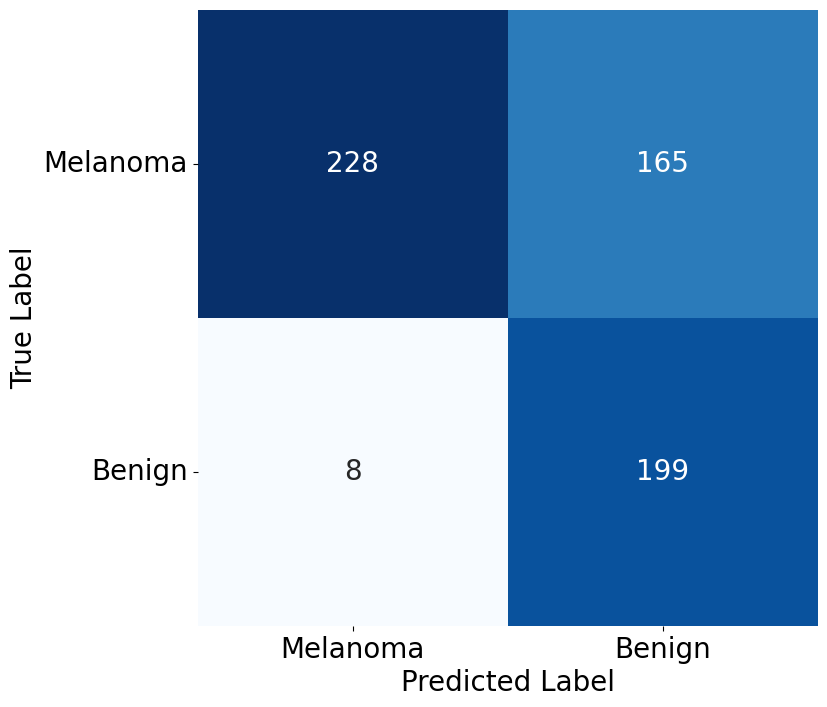

In [20]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

cm = confusion_matrix(y_true, y_pred)

# Define the font size
font_size = 20

# Plot the confusion matrix
plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=unique_labels, yticklabels=unique_labels, annot_kws={"fontsize": font_size}, cbar=False)
plt.xlabel("Predicted Label", fontsize=font_size)
plt.ylabel("True Label", fontsize=font_size)
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size, rotation=0)
plt.show()



In [21]:
TP=cm[1,1]
TN=cm[0,0]
FP=cm[0,1]
FN=cm[1,0]
print('TP: %f' % TP,'TN: %f' % TN, 'FP: %f' % FP, 'FN: %f' % FN)

TP: 199.000000 TN: 228.000000 FP: 165.000000 FN: 8.000000


In [22]:
from sklearn.metrics import roc_curve, auc,roc_auc_score
acc=(TP+TN)/float(TN+FP+TP+FN)
print('acc: %.5f' % acc)
specificity=TN/float(TN+FP)
print('Specificity: %.5f' % specificity)
recall=TP/float(TP+FN)
print(' Recall: %.5f' % recall)
precision=TP/float(TP+FP)
print(' Precision: %.5f' % precision)
f1=(2*precision*recall)/(recall+precision)
print('F1 Score: %.5f' % f1)


acc: 0.71167
Specificity: 0.58015
 Recall: 0.96135
 Precision: 0.54670
F1 Score: 0.69702


In [ ]:
import numpy as np
from sklearn.metrics import roc_auc_score, matthews_corrcoef, cohen_kappa_score

# Generate labels and predictions for AUC, MCC, Kappa
y_true = np.array([1] * TP + [0] * TN + [1] * FN + [0] * FP)  # True labels
y_pred = np.array([1] * TP + [0] * TN + [0] * FN + [1] * FP)  # Predicted labels

# Compute AUC
auc_score = roc_auc_score(y_true, y_pred)

# Compute MCC
mcc_score = matthews_corrcoef(y_true, y_pred)

# Compute Cohen’s Kappa
kappa_score = cohen_kappa_score(y_true, y_pred)

# Print Metrics
print(f"AUC: {auc_score:.5f}")
print(f"MCC: {mcc_score:.5f}")
print(f"Cohen's Kappa: {kappa_score:.5f}")


AUC: 0.75947
MCC: 0.63311
Cohen's Kappa: 0.58216


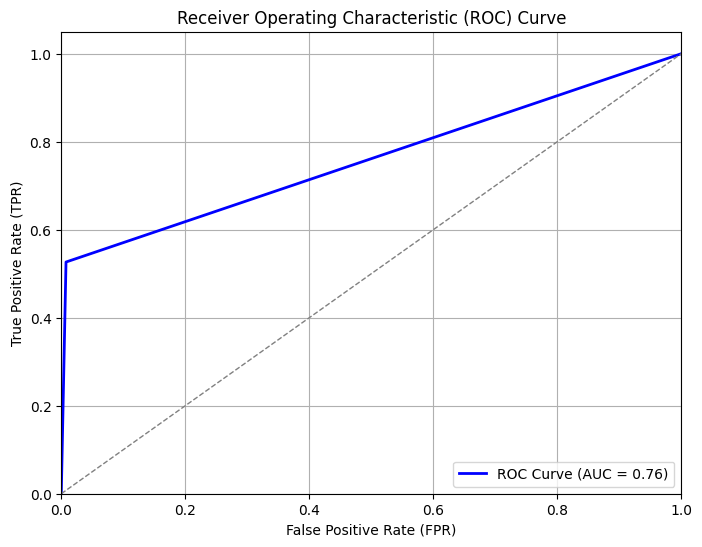

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Generate labels and predictions for AUC, MCC, Kappa
y_true = np.array([1] * TP + [0] * TN + [1] * FN + [0] * FP)  # True labels
y_pred = np.array([1] * TP + [0] * TN + [0] * FN + [1] * FP)  # Predicted labels

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)  # Compute AUC

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)  # Diagonal line

# Formatting the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid()

# Show the plot
plt.show()
